<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/PRACTICE_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CIFAR-10**

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras.applications.nasnet import decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

from tensorflow.keras.datasets import cifar10

from sklearn.metrics import classification_report,confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [ ]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 50

# The data, split between train and test sets:

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


# See shape

In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


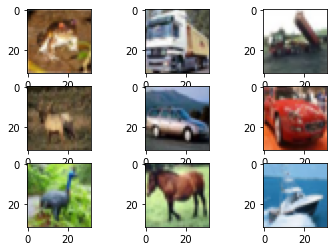

In [ ]:
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

# Augmentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=360,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')
datagen.fit(x_train)

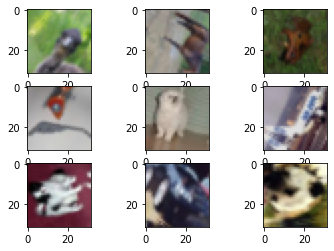

In [ ]:
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

# One how encoding

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [ ]:
classes_names = np.unique(y_train)

# Normalize

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# Steps

In [ ]:
train_steps_per_epoch = x_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = x_test.shape[0] // BATCH_SIZE

# Model

In [ ]:
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
len(base_model.layers)

707

In [ ]:
# base_model.summary()

# Fine Tune

Freeze layer

In [ ]:
# base_model.trainable = False

In [ ]:
# for layer in base_model.layers[:350]:
#   layer.trainable = False

In [ ]:
# base_model.summary()

In [ ]:
average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
dense1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(average_pooling_layer)
# dense2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
dense3 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
dense4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense3)
dense5 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense4)
dropout1 = Dropout(0.5)(dense5)
prediction_layer = Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout1)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [ ]:
model.compile(optimizer=Adam(lr=9e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.summary()

# Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='cifar10_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
cb_list = [early_stop, model_checkpoint, reduce_lr_rate]

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          # validation_data=(x_test, y_test),
          callbacks=cb_list,
          validation_split=0.2,
          shuffle=True)

Epoch 1/50
1250/1250 [==============================] - 226s 180ms/step - loss: 8.3782 - accuracy: 0.5519 - val_loss: 3.3658 - val_accuracy: 0.7711 - lr: 9.0000e-05
Epoch 2/50
1250/1250 [==============================] - 220s 176ms/step - loss: 2.4309 - accuracy: 0.7669 - val_loss: 1.6203 - val_accuracy: 0.8159 - lr: 9.0000e-05
Epoch 3/50
1250/1250 [==============================] - 220s 176ms/step - loss: 1.4089 - accuracy: 0.8262 - val_loss: 1.1404 - val_accuracy: 0.8382 - lr: 9.0000e-05
Epoch 4/50
1250/1250 [==============================] - 220s 176ms/step - loss: 1.0331 - accuracy: 0.8621 - val_loss: 0.9802 - val_accuracy: 0.8384 - lr: 9.0000e-05
Epoch 5/50
1250/1250 [==============================] - 220s 176ms/step - loss: 0.7939 - accuracy: 0.8971 - val_loss: 0.8609 - val_accuracy: 0.8471 - lr: 9.0000e-05
Epoch 6/50
1250/1250 [==============================] - 219s 176ms/step - loss: 0.6483 - accuracy: 0.9185 - val_loss: 0.8244 - val_accuracy: 0.8474 - lr: 9.0000e-05
Epoch 7/50

# Graph

## Accuracy

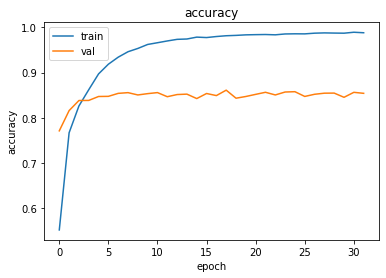

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

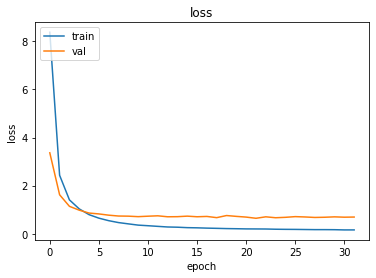

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Scores

In [ ]:
test_model = tf.keras.models.load_model('cifar10_model.h5')

In [ ]:
scores = test_model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 18s 59ms/step - loss: 0.6604 - accuracy: 0.8565


In [ ]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.6604465842247009
Test accuracy: 0.8565000295639038


# Evaluate

In [ ]:
y_pred_probabilities = test_model.predict(x_test)

In [ ]:
y_pred_ans = np.argmax(y_pred_probabilities,axis=1)

In [ ]:
y_test = np.argmax(y_test,axis=1)

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_ans)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Without Normalize

Confusion matrix, without normalization
[[910   9  26  11   2   2   3   6  21  10]
 [ 10 920   2   3   0   0   0   0  12  53]
 [ 24   3 833  31  34  29  20  23   2   1]
 [ 13   6  48 706  49 104  25  28   9  12]
 [ 10   2  41  25 845  24  10  38   5   0]
 [ 12   1  27 130  19 771   7  26   2   5]
 [  9   4  24  47  21  16 870   2   2   5]
 [ 12   1  11  12  36  40   1 881   1   5]
 [ 44  12   4   6   2   2   1   0 915  14]
 [ 19  42   5   5   0   1   0   4  10 914]]


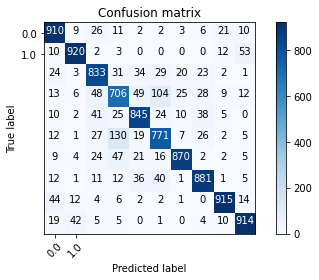

In [ ]:
plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.91  0.009 0.026 0.011 0.002 0.002 0.003 0.006 0.021 0.01 ]
 [0.01  0.92  0.002 0.003 0.    0.    0.    0.    0.012 0.053]
 [0.024 0.003 0.833 0.031 0.034 0.029 0.02  0.023 0.002 0.001]
 [0.013 0.006 0.048 0.706 0.049 0.104 0.025 0.028 0.009 0.012]
 [0.01  0.002 0.041 0.025 0.845 0.024 0.01  0.038 0.005 0.   ]
 [0.012 0.001 0.027 0.13  0.019 0.771 0.007 0.026 0.002 0.005]
 [0.009 0.004 0.024 0.047 0.021 0.016 0.87  0.002 0.002 0.005]
 [0.012 0.001 0.011 0.012 0.036 0.04  0.001 0.881 0.001 0.005]
 [0.044 0.012 0.004 0.006 0.002 0.002 0.001 0.    0.915 0.014]
 [0.019 0.042 0.005 0.005 0.    0.001 0.    0.004 0.01  0.914]]


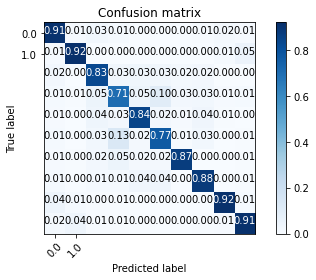

In [ ]:
plot_confusion_matrix(cm, classes_names, True)

In [ ]:
print('Classification report')
print(classification_report(y_true=y_test, y_pred=y_pred_ans))

Classification report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1000
           1       0.92      0.92      0.92      1000
           2       0.82      0.83      0.82      1000
           3       0.72      0.71      0.71      1000
           4       0.84      0.84      0.84      1000
           5       0.78      0.77      0.78      1000
           6       0.93      0.87      0.90      1000
           7       0.87      0.88      0.88      1000
           8       0.93      0.92      0.92      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

